**Table of Contents**
1. [Recreearea Sesiunii Spark](#recrearea-sesiunii-spark)
1. [Citirea Seturilor De Date](#citirea-seturilor-de-date)
1. [Pipeline Pentru Random Forest](#pipeline-pentru-random-forest)
   1. [Preprocesare](#preprocesare)
   1. [Crearea Pipeline-ului](#crearea-pipeline-ului)
   1. [Evaluarea Modelului](#evaluarea-modelului)
1. [Random Forest Pe Intregul Set De Date](#random-forest-pe-intregul-set-de-date)
   1. [Antrenarea Modelului Pe Intregul Set De Date](#antrenarea-modelului-pe-intregul-set-de-date)
   1. [Evaluarea Modelului Pe Intregul Set De Date](#evaluarea-modelului-pe-intregul-set-de-date)
   
   

# Recrearea Sesiunii Spark


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
import pyspark.sql.types as T
import plotly.express as px

sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

In [21]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName('Proiect')
    .master('local[*]')
    .config('spark.sql.shuffle.partitions', 48)
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '16g')
    .config('spark.sql.execution.arrow.pyspark.enabled', True)
    .config('spark.executor.memoryOverheadFactor', '0.20')
    .config('spark.dynamicAllocation.enabled', True)
    .getOrCreate()
)
spark

# Citirea Seturilor De Date

In [15]:
import os
data_path = os.path.join(os.getcwd()+"/proiect/input/")
output_path = os.path.join(os.getcwd()+"/proiect/output/")

In [16]:
mini_train_df = spark.read.parquet(output_path+"mini_train_df.parquet")
mini_test_df = spark.read.parquet(output_path+"mini_test_df.parquet")

In [17]:
mini_train_df.count(), mini_test_df.count()

(36820, 4772)

# Pipeline Pentru Random Forest

## Preprocesare 

In [18]:
from pyspark.ml import Transformer
from pyspark.sql import DataFrame
from datetime import datetime
from pyspark.ml.feature import StringIndexer
# pt a salva pipelineul
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable, DefaultParamsReader
from pyspark.ml.param import Param, Params


class BaseTransformer(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    """
    O clasa de baza pentru toate transformarile custom pe care le vom face.
    """

    def __init__(self, inputCol=None, outputCol=None):
        super(BaseTransformer, self).__init__()
        self.inputCol = Param(self, "inputCol", "Input column name")
        self.outputCol = Param(self, "outputCol", "Output column name")
        self._setDefault(inputCol=inputCol, outputCol=outputCol)
        self._set(inputCol=inputCol, outputCol=outputCol)

    def getInputCol(self):
        """
        Getter pentru coloana de input.
        """
        return self.getOrDefault(self.inputCol)

    def getOutputCol(self):
        """
        Getter pentru coloana de output.
        """
        return self.getOrDefault(self.outputCol)

    @classmethod
    def read(cls):
        """
        Returneaza un cititor pentru clasa
        """
        return DefaultParamsReader(cls)

    @classmethod
    def load(cls, path):
        """
        Incarca o instanta a clasei dintr-un fisier.
        """
        return cls.read().load(path)

    def save(self, path):
        """
        Salveaza modeulul intr-un fisier shortcut pentru `write().overwrite().save(path)`
        """
        self.write().overwrite().save(path)


split_date_schema = T.StructType([
    T.StructField("month", T.IntegerType(), True),
    T.StructField("day_bucket", T.IntegerType(), True),
    T.StructField("day_of_week", T.IntegerType(), True),
    T.StructField("rounded_hour", T.IntegerType(), True)
])  # structura de date pentru coloanele rezultate


@F.udf(returnType=split_date_schema)
def split_date(date_str: str):
    date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    day = date.day
    day_bucket = 1 if day <= 10 else 2 if day <= 20 else 3
    return {
        "month": date.month,
        "day_bucket": day_bucket,
        "day_of_week": date.weekday(),
        "rounded_hour": date.hour
    }


class DateTransformer(BaseTransformer):
    """
    Un transformer care va separa coloana de date in mai multe coloane: luna, ziua, ziua saptamanii si ora rotunjita.
    """
    # daca flatten este True atunci se va destructura coloana de output
    def __init__(self, inputCol=None, outputCol=None, flatten=False):
        super(DateTransformer, self).__init__(
            inputCol=inputCol, outputCol=outputCol)
        self.flatten = Param(
            self, "flatten", "Whether to flatten the date column")
        self._setDefault(flatten=flatten)
        self._set(flatten=flatten)

    def _transform(self, df: DataFrame):
        if not self.getOutputCol() and not self.getFlatten():
            raise Exception(
                "You must specify an output column or flatten the output.")
        if self.getFlatten() and self.getOutputCol():
            raise Exception(
                "You can't specify an output column and flatten the output at the same time.")

        if self.getFlatten():
            return df.withColumn("temp", split_date(F.col(self.getInputCol())))\
                .select(df.columns + [F.col("temp.*")]).drop("temp")
        return df.withColumn(self.getOutputCol(), split_date(F.col(self.getInputCol())))

    @staticmethod
    def getFlattenCols():
        return ["month", "day_bucket", "day_of_week", "rounded_hour"]

    def getFlatten(self):
        """
        Getter pentru parametrul flatten.
        """
        return self.getOrDefault(self.flatten)


class LocationTransformer(BaseTransformer):
    """
    Un transformer care va imparti locatiile in categorii de risc in functie de procentajul de tranzactii frauduloase.
    """
    def __init__(self, inputCol=None, outputCol=None):
        super(LocationTransformer, self).__init__(
            inputCol=inputCol, outputCol=outputCol)

    def _transform(self, df: DataFrame):
        grouped_df = df.groupBy(self.getInputCol()).agg(F.count('*').alias('total_transactions'),
                                                        F.sum(F.col('Is Fraudulent')).alias('total_fraudulent_transactions'))\
            .withColumn('fraud_percentage', F.col('total_fraudulent_transactions') / F.col('total_transactions') * 100)\
            .withColumn(self.getOutputCol(),
                        F.when(F.col('fraud_percentage') <= 5, 'Low Risk')
                        .when((F.col('fraud_percentage') > 5) & (F.col('fraud_percentage') <= 20), 'Medium Risk')
                        .otherwise('High Risk'))\
            .drop('total_transactions', 'total_fraudulent_transactions', 'fraud_percentage')

        return df.join(F.broadcast(grouped_df), self.getInputCol(), 'left')
    
class ClassWeightTransformer(BaseTransformer):

    """
    Un transformer care va adauga un weight pentru clasa pozitiva.
    """
    positiveWeight = Param(
        Params._dummy(), "positiveWeight", "Positive weight for the class")  # pentru a putea folosi parametrul in CrossValidator

    def __init__(self, inputCol=None, outputCol=None, positiveWeight=1.0):
        super(ClassWeightTransformer, self).__init__(
            inputCol=inputCol, outputCol=outputCol)
        self._setDefault(positiveWeight=positiveWeight)
        self._set(positiveWeight=positiveWeight)

    def setPositiveWeight(self, value):

        self._set(positiveWeight=value)

    def getPositiveWeight(self):

        return self.getOrDefault(self.positiveWeight)

    def _transform(self, df: DataFrame):

        return df.withColumn(self.getOutputCol(), F.when(F.col(self.getInputCol()) == 1, self.getPositiveWeight()).otherwise(1.0))

## Crearea Pipeline-ului

Dupa cum am vazut, regresia logistica nu a dat rezultate bune, neputand indentifica corect nicio tranzactie frauduloasa. In acest sens, vom incerca un alt model de clasificare, Random Forest. Acesta este un model de invatare supervizata care poate fi folosit atat pentru clasificare cat si pentru regresie. Random Forest este un ansamblu de arbori de decizie, antrenati pe subseturi ale setului de date initial cu un numar diferit de caracteristici. In final, clasificarea este data de votul majoritar al arborilor de decizie. _(Wisdom of the crowd)_


In [7]:
from pyspark.ml.feature import VectorAssembler, Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

max_acc_days = 365

date_transformer = DateTransformer(
    "Transaction Date", flatten=True)
location_transformer = LocationTransformer(
    "Customer Location", "fraud_risk_category")
fraud_risk_indexer = StringIndexer(
    inputCol="fraud_risk_category", outputCol="fraud_risk_category Index")
splits = list(range(0, int(max_acc_days) + 50, 50))
age_bucketizer = Bucketizer(
    splits=splits, inputCol="Account Age Days", outputCol="Account Age Days Bucket", handleInvalid="skip")
cw_transformer = ClassWeightTransformer(
    inputCol="Is Fraudulent", outputCol="classWeights", positiveWeight=1.0)

input_cols = ['month', 'day_bucket', 'day_of_week', 'rounded_hour',
              'Transaction Amount', 'fraud_risk_category Index', "Account Age Days Bucket"]

feature_assembler = VectorAssembler(inputCols=input_cols, outputCol='features')


rf = RandomForestClassifier(featuresCol='features',
                            labelCol='Is Fraudulent', weightCol='classWeights')

param_grid = (
    ParamGridBuilder()
    # 3 valori pentru positiveWeight
    .addGrid(cw_transformer.positiveWeight, [1.0, 2.0, 5.0])
    .addGrid(rf.numTrees, [10, 20, 30])
    # un numar relativ mic pentru a evita overfitting, avand in vedere disproportionarea claselor
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.impurity, ['gini', 'entropy'])  # functia de split
    # procentul de date folosit pentru antrenare
    .addGrid(rf.subsamplingRate, [0.8, 1.0])
    # numarul de features folosit pentru split
    .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
    # numarul minim de instante pentru a face split
    .addGrid(rf.minInstancesPerNode, [1, 2, 5])
    # minimul de informatii castigate pentru a face split
    .addGrid(rf.minInfoGain, [0.0, 0.1, 0.2])
    .build()
)
evaluator = BinaryClassificationEvaluator(
    labelCol='Is Fraudulent', metricName='areaUnderROC',weightCol='classWeights')

pipe = Pipeline(stages=[date_transformer, location_transformer, fraud_risk_indexer,
                age_bucketizer, feature_assembler, cw_transformer, rf])

cv = CrossValidator(estimator=pipe, estimatorParamMaps=param_grid,
                    evaluator=evaluator, numFolds=3, parallelism=12)

cv_model = cv.fit(mini_train_df)

best_rf_model = cv_model.bestModel.stages[-1]

cv_model.bestModel.write().overwrite().save(output_path+"models/best_rf_model")

## Evaluarea Modelului

In [8]:
summary = best_rf_model.summary

print(f"Area under ROC: {summary.areaUnderROC}")
print(f"Accuracy: {summary.accuracy}")

Area under ROC: 0.9794471136542888
Accuracy: 0.9424005099717694


In [9]:
fpr_values = [row['FPR'] for row in summary.roc.select('FPR').collect()]
tpr_values = [row['TPR'] for row in summary.roc.select('TPR').collect()]
fig = px.line(x=fpr_values,
              y=tpr_values,
              labels={'x': 'FPR', 'y': 'TPR'},
              title='ROC Curve')

fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(
    color='red', dash='dash'), name='Random Guess')

fig.show()

In [10]:
best_rf_model.extractParamMap()

{Param(parent='RandomForestClassifier_bbafb6be2c16', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [11]:
positive_weight_value = cv_model.bestModel.stages[-2].getOrDefault(
    cw_transformer.positiveWeight)
print("Positive Weight Value:", positive_weight_value)

Positive Weight Value: 5.0


In [12]:
best_rf_model.featureImportances

SparseVector(7, {0: 0.0002, 1: 0.0004, 2: 0.0006, 3: 0.0012, 4: 0.0815, 5: 0.85, 6: 0.0661})

In [13]:
imp_map = {col: coef for col, coef in zip(
    input_cols, best_rf_model.featureImportances.toArray())}
imp_map

{'month': 0.00023953040440814473,
 'day_bucket': 0.00038249964113899905,
 'day_of_week': 0.0005625481246826545,
 'rounded_hour': 0.0012282517719161203,
 'Transaction Amount': 0.08151130197815866,
 'fraud_risk_category Index': 0.8499995972202958,
 'Account Age Days Bucket': 0.06607627085939961}

Observam ca aceleasi caracteristici sunt importante si in cazul _Random Forest_ : `Transaction Amount`, `Account Age Days Bucket` si `fraud_risk_category Index`.

In [40]:
def evaluate_model(predictions, evaluator):
    """
    Functie pentru evaluarea modelului.
    """
    label = 'Is Fraudulent'
    correct = predictions.filter(
        predictions[label] == predictions["prediction"]).count()
    wrong = predictions.filter(
        predictions[label] != predictions["prediction"]).count()
    tp = predictions.filter(predictions[label] == 1.0).filter(
        predictions[label] == predictions["prediction"]).count()
    fp = predictions.filter(predictions[label] == 1.0).filter(
        predictions[label] != predictions["prediction"]).count()
    tn = predictions.filter(predictions[label] == 0.0).filter(
        predictions[label] == predictions["prediction"]).count()
    fn = predictions.filter(predictions[label] == 0.0).filter(
        predictions[label] != predictions["prediction"]).count()

    accuracy = (tp+tn)/(tp+tn+fp+fn)

    if tp == 0:
        precision = 0
        recall = 0
    else:
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)

    print("Correct: ", correct)
    print("Wrong: ", wrong)
    print("True Positives: ", tp)
    print("False Positives: ", fp)
    print("True Negatives: ", tn)
    print("False Negatives: ", fn)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print(
        f"Evaluator {evaluator.getMetricName()}: {evaluator.evaluate(predictions)}")
    return pd.DataFrame({
        "Predicted Fraud": [tp, fp],
        "Predicted OK": [fn, tn]
    }, index=["Actual Fraud", "Actual OK"])

In [41]:
from pyspark.ml import PipelineModel

loaded_model = PipelineModel.load(output_path+"models/best_rf_model")

best_rf_model = loaded_model.stages[-1]

In [42]:
predictions = loaded_model.transform(mini_test_df)
predictions.select("prediction", 'Is Fraudulent',
                   "rawPrediction", "probability").show(truncate=False)

+----------+-------------+----------------------------------------+-----------------------------------------+
|prediction|Is Fraudulent|rawPrediction                           |probability                              |
+----------+-------------+----------------------------------------+-----------------------------------------+
|0.0       |0            |[19.653125236085177,0.3468747639148169] |[0.9826562618042592,0.01734373819574085] |
|0.0       |0            |[19.695016038061997,0.3049839619379998] |[0.9847508019031,0.015249198096899994]   |
|0.0       |0            |[19.747945801791886,0.25205419820811203]|[0.9873972900895944,0.012602709910405603]|
|0.0       |0            |[19.408931163838766,0.5910688361612312] |[0.9704465581919385,0.029553441808061565]|
|0.0       |0            |[19.620930608389926,0.37906939161006953]|[0.9810465304194965,0.01895346958050348] |
|0.0       |0            |[19.738420822366248,0.2615791776337484] |[0.9869210411183126,0.013078958881687421]|
|0.0      

In [43]:
cm_df = evaluate_model(predictions, evaluator)

Correct:  4702
Wrong:  70
True Positives:  237
False Positives:  1
True Negatives:  4465
False Negatives:  69
Accuracy:  0.9853310980720872
Precision:  0.9957983193277311
Recall:  0.7745098039215687
Evaluator areaUnderROC: 0.9959085972280398


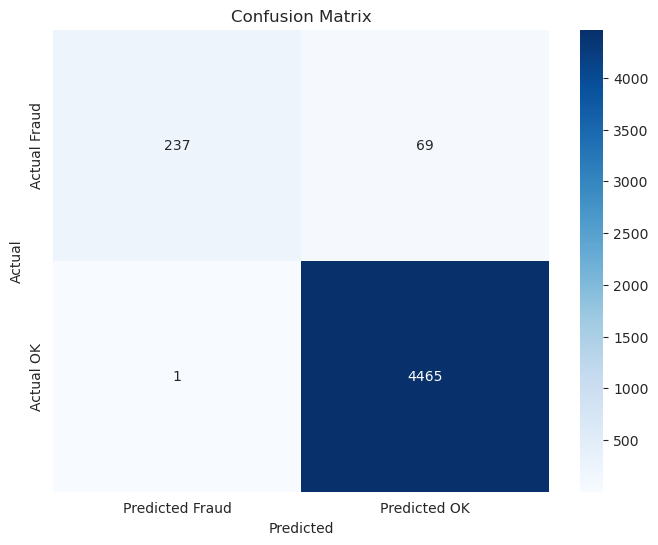

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Dupa cum putem vedea in matricea de confuzie, avem un numar destul de mare de `False Negative`, insa avem si un numar mult mai mare decat `0` in cazul _Regresiei Logistice_ de transactii frauduloase identificate corect. In cazul acetui tip de problema este preferabil sa avem un numar mai mare de `False Positive` decat `False Negative`, deoarece in cazul `False Negative` pierderile sunt mult mai mari.


In [45]:
from pyspark.ml import PipelineModel

loaded_model = PipelineModel.load(output_path+"models/best_rf_model")

In [46]:
rf_loaded = loaded_model.stages[-1]

In [47]:
rf_loaded.extractParamMap()

{Param(parent='RandomForestClassifier_bbafb6be2c16', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [48]:
rf_loaded.params

[Param(parent='RandomForestClassifier_bbafb6be2c16', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'),
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'),
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'),
 Param(parent='RandomForestClassifier_bbafb6be2c16', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'a

In [49]:
rf_params = {param.name: rf_loaded.getOrDefault(
    param) for param in rf_loaded.params if rf_loaded.isSet(param)}

rf_params

{'featureSubsetStrategy': 'auto',
 'featuresCol': 'features',
 'impurity': 'gini',
 'labelCol': 'Is Fraudulent',
 'maxDepth': 5,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 2,
 'numTrees': 20,
 'subsamplingRate': 1.0,
 'weightCol': 'classWeights'}

In [50]:
weight = loaded_model.stages[-2].getPositiveWeight()
weight

5.0

# Random Forest Pe Intregul Set De Date

## Antrenarea Modelului Pe Intregul Set De Date

Cum random _Random Forest_ a dat rezultate mai bune decat _Regresia Logistica_, il vom folosi pentru a antrena modelul pe intregul set de date. 

In [22]:
train_df = spark.read.parquet(
    data_path+"Fraudulent_E-Commerce_Transaction_Data.parquet")
test_df = spark.read.parquet(
    data_path+"Fraudulent_E-Commerce_Transaction_Data_2.parquet")

In [26]:
from pyspark.ml import PipelineModel
from pyspark.ml.classification import RandomForestClassifier
loaded_model = PipelineModel.load(output_path+"models/best_rf_model")

ml_model = loaded_model.stages[-1]

new_rf = RandomForestClassifier(**{param.name: ml_model.getOrDefault(
    param) for param in ml_model.params if ml_model.isSet(param)})

cw_tr= loaded_model.stages[-2]
new_tr= ClassWeightTransformer(inputCol=cw_tr.getInputCol(), outputCol=cw_tr.getOutputCol(), positiveWeight=cw_tr.getPositiveWeight())

pipe_new = Pipeline(stages=loaded_model.stages[:-2] + [new_tr, new_rf])

pipe_new_model = pipe_new.fit(train_df)

pipe_new_model.write().overwrite().save(output_path+"models/whole_train_model")

## Evaluarea Modelului Pe Intregul Set De Date

In [27]:
summary_all = pipe_new_model.stages[-1].summary

print(f"Area under ROC: {summary_all.areaUnderROC}")
print(f"Accuracy: {summary_all.accuracy}")

Area under ROC: 0.8128311914253215
Accuracy: 0.8347122440485346


In [28]:
fpr_values = [row['FPR'] for row in summary_all.roc.select('FPR').collect()]
tpr_values = [row['TPR'] for row in summary_all.roc.select('TPR').collect()]
fig = px.line(x=fpr_values,
              y=tpr_values,
              labels={'x': 'FPR', 'y': 'TPR'},
              title='ROC Curve')

fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(
    color='red', dash='dash'), name='Random Guess')

fig.show()

In [51]:
from  pyspark.ml import PipelineModel

pipe_new_model = PipelineModel.load(output_path+"models/whole_train_model")

In [52]:
predictions = pipe_new_model.transform(test_df)
predictions.select("prediction", 'Is Fraudulent',
                   "rawPrediction", "probability").show(truncate=False)

+----------+-------------+---------------------------------------+----------------------------------------+
|prediction|Is Fraudulent|rawPrediction                          |probability                             |
+----------+-------------+---------------------------------------+----------------------------------------+
|0.0       |0            |[17.603237849859944,2.3967621501400576]|[0.8801618924929973,0.11983810750700288]|
|0.0       |0            |[17.683914817982853,2.316085182017152] |[0.8841957408991424,0.11580425910085759]|
|0.0       |0            |[17.58506262921808,2.414937370781924]  |[0.8792531314609038,0.12074686853909618]|
|0.0       |0            |[17.56357322079507,2.4364267792049303] |[0.8781786610397535,0.12182133896024652]|
|0.0       |0            |[17.56357322079507,2.4364267792049303] |[0.8781786610397535,0.12182133896024652]|
|0.0       |0            |[17.54890368929776,2.451096310702241]  |[0.877445184464888,0.12255481553511205] |
|0.0       |0            |[1

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol='Is Fraudulent', metricName='areaUnderROC',weightCol='classWeights')
cm_df = evaluate_model(predictions, evaluator)

Correct:  22622
Wrong:  1012
True Positives:  1075
False Positives:  147
True Negatives:  21547
False Negatives:  865
Accuracy:  0.9571803334179572
Precision:  0.8797054009819967
Recall:  0.5541237113402062
Evaluator areaUnderROC: 0.9704474645772241


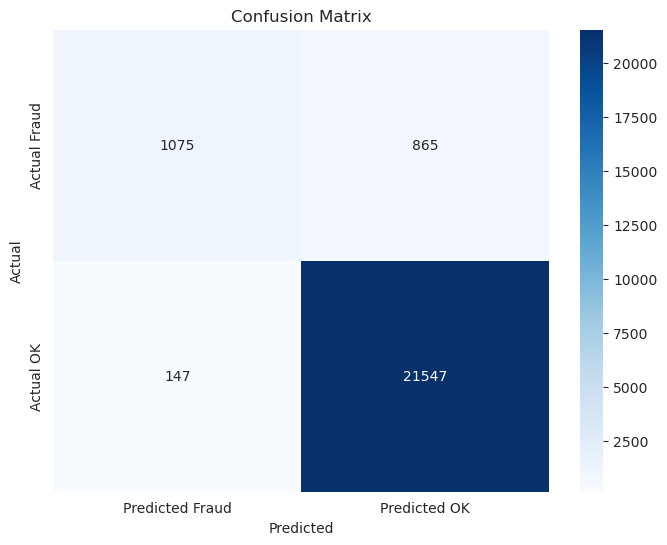

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Putem vedea ca modelul nu este cel mai bun, avand o tendinta de `False Negativ` destul de mare, insa avem si un numar destul de mare de tranzactii frauduloase identificate corect. Aceasta tendinta este oarecum normala, deoarece avem un set de date destul de dezechilibrat, cu un numar foarte mic de tranzactii frauduloase. In asemenea situatii este preferabil sa avem un numar mai mare de `False Positive` decat `False Negative`, deoarece in cazul `False Negative` pierderile sunt mult mai mari.